In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Модуль для кодировки текстовых данных
import category_encoders as ce

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  


from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [2]:
#  Сохраним верию пакетов для возможности воспроизведения среды
!pip freeze > requirement.txt

In [3]:
RANDOM_SEED  = 42
DIR_NAME = '/kaggle/input/sf-booking/'

In [4]:
# Подгрузим наши датасеты
df_train = pd.read_csv(DIR_NAME + 'hotels_train.csv')
df_test = pd.read_csv(DIR_NAME + 'hotels_test.csv')
sample_submission = pd.read_csv(DIR_NAME + 'submission.csv')

In [5]:
# Обьединим тестовый и тренировочный датасет для удобства редактирования 


df_test['part'] = 1 #добавим столбец в датасеты для того, чтобы в последствии их можно было разделить
df_train['part'] = 0 #добавим столбец в датасеты для того, чтобы в последствии их можно было разделить

hotels = pd.concat([df_test,df_train],ignore_index=True)

#Заменим пропуски 0 в столбце т.к. в тестовых данных его не было
hotels['reviewer_score'].fillna(0,inplace=True) 

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
#отфильтруем датафрейм по пропускам
hotels.isnull().sum()
# в строках координат по 3268 пропуска

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
part                                             0
reviewer_score                                   0
dtype: int64

Займемся удалением дубликатов. Для начала посмотрим имеются ли они у нас в датафрейме

In [8]:
hotels[hotels['part'] == 0].duplicated().value_counts()

False    386496
True        307
dtype: int64

In [9]:
df_mask = hotels[(hotels['part'] == 0)&(hotels.duplicated() == True)].index
hotels.drop(df_mask,axis=0,inplace=True)

# Создание признаков

 Добавим новые признаки в наш датасет:

In [10]:
# Выведем в отдельный признак страну и город где находится отель из адреса

def country(string):
    string = string.split(' ')
    if string[-1] == 'Kingdom':
        return f'{string[-2]} {string[-1]}'
    else: return string[-1]

def city(string):
    string = string.split(' ')
    if string[-1] == 'Kingdom':
        return string[-5]
    else: return string[-2]
    
hotels['country'] = hotels['hotel_address'].apply(country)
hotels['city'] = hotels['hotel_address'].apply(city)

# удалим столбец с адресом из датафрейма
hotels.drop('hotel_address',axis=1,inplace=True)

In [11]:
# Заменим значения координат отелей на координаты городов где находятся эти отели.
# Координаты возьмем из Google maps
    

lattitude_city = {'Milan': 45.46867140289774,
           'Vienna': 48.21015022485146,
           'Paris': 48.87345485476049, 
           'Barcelona': 41.39342109175948,
           'London': 51.51958660982807, 
           'Amsterdam': 52.37232939361723}

longitude_city = {'Milan': 9.182530394907893,
           'Vienna': 16.388865082581233,
           'Paris': 2.3443453336359696,
           'Barcelona': 2.1583497824836617,
           'London': -0.11808564889268129, 
           'Amsterdam': 4.897961568914184}


hotels['lat'] = hotels[['city','lat']].apply(lambda x: lattitude_city[x['city']],axis=1)
hotels['lng'] = hotels[['city','lng']].apply(lambda x: longitude_city[x['city']],axis=1)


Займемся признаками positive и negative review 

In [12]:
# Найдем строки где в тексте комментария указаны только цифры
lst_review = []
for i in hotels.index:
    neg = hotels['negative_review'][i].strip().replace(' ', '')
    pos = hotels['positive_review'][i].strip().replace(' ', '')
    if neg.isdecimal():
        lst_review.append(i)
    if pos.isdecimal():
        lst_review.append(i)
print('Индексы строк, где в отзывах только числа:',*lst_review )  

Индексы строк, где в отзывах только числа: 14941 22455 22455 43611 78986 101110 126330 139010 140774 155018 178879 187623 205163 219197 220046 261740 283115 325350 384830 396859 411026 426732 502262


In [13]:
# Заменим цифровые значения на фактический позитивный или негативный оттенок:

negative_digit= [14941, 22455, 126330, 187619, 205155, 325282]

positive_digit = [43611, 78986, 101110, 139010, 140774, 155017, 
                   178878, 219188, 220037, 261714, 283073, 384703, 
                   396718, 410871, 426557, 501977]
    
for i in negative_digit:
    hotels.iloc[i, 6] = 'Negative'
    hotels.iloc[i, 9] = '0'
for j in positive_digit:
    hotels.iloc[j, 6] = '0'
    hotels.iloc[j, 9] = 'Positive'

In [14]:
# Создадим списки наиболее часто встречающихся ложно положительных и ложно отрицательных комментариев
piositive_comm = ['no negative', 'nothing','none',' ', 'nothing really', 'n a',
                     'no complaints','all good','nothing at all','nothing to dislike','none','nil',
                     'everything was perfect','can t think of anything','absolutely nothing',
                    'everything was great','nothing to complain about','nothing not to like',
                    'having to leave','na','i liked everything','no','everything was good',
                    'liked everything','see above','nothing all good','everything was fine',
                    'all was good','nothing it was perfect','non','nothing comes to mind',
                     'there was nothing i didn t like','no complaints at all','we liked everything',
                    'nothing i didn t like','nothing everything was perfect','no negatives',
                     'there was nothing to dislike','nothing everything was great','nothing to report',
                     'it was all good','there was nothing we didn t like','loved everything','no thing',
                     'no complaints','all ok','all good','there was nothing not to like',
                    'no issues','nothing I can think of','nothing to say','no dislikes',
                     'nothing to mention','no','everything was excellent','nothing we didn t like',
                     'nothing to complain','nada','nothing bad to say','nil','i loved everything',
                     'nothing bad','nothing could have been better','all great','liked it all'
                    ]
negative_comm =['no Positive','nothing','location only','only the location','n a','na','none',' ']

# Отредактируем комментарии 

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.lower().strip())
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: "Positive" if x in piositive_comm else x)

hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.lower().strip())
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: "Negative" if x in negative_comm else x)



In [15]:
#Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

sid_obj = SentimentIntensityAnalyzer()
hotels['negative_review_sentiments'] = hotels['negative_review'].apply(lambda x: sid_obj.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review'].apply(lambda x: sid_obj.polarity_scores(x))

hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

Создадим признак отношения числа слов положительных и отрицательных комментариев к медианному значению количества слов в положительном и отрицательном комментарии:

In [16]:
#У нас в дата фрейме в столбцах где указано число слов в отзывах в топе присутствуют 0, 
#хотя у нас нет пустых строк в столбцах с комментариями:
print(
    hotels['review_total_positive_word_counts'].value_counts()[0:3],
    '\n',
    hotels['review_total_negative_word_counts'].value_counts()[0:3]
)

0    35923
6    26901
5    26824
Name: review_total_positive_word_counts, dtype: int64 
 0    127810
2     24632
3     18129
Name: review_total_negative_word_counts, dtype: int64


In [17]:
# Посчитаем реальное количество слов в каждом комментарии
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split()))
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: len(x.split()))

In [18]:
# Cоздаем признак
mean_positive_words_count = hotels['review_total_positive_word_counts'].median()
mean_negative_words_count = hotels['review_total_negative_word_counts'].median()
hotels['words_negative_count_ratio'] = hotels['review_total_negative_word_counts'] / mean_negative_words_count
hotels['words_positive_count_ratio'] = hotels['review_total_positive_word_counts'] / mean_positive_words_count

In [19]:
# Удалим более ненужные нам столбцы
hotels.drop(['review_total_positive_word_counts','review_total_negative_word_counts'],axis=1,inplace=True)



Создадим признак национальности рецезента и страны где находится отель.
Если они совпадают - 1, если нет 0

In [20]:
#для начала уберем все пробелы в начале и конце строки
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

hotels['native_country'] = hotels['reviewer_nationality'] == hotels['country']
hotels['native_country'] = hotels['native_country'].astype(int)

Изменим признак даты отзыва и выделим из него день недели и месяц посещения отеля

In [21]:
#Приведем столбец к формату datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'],format="%m/%d/%Y")

In [22]:
#Создаем признаки и удаляем столбец с датой посещения
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day_of_week'] = hotels['review_date'].dt.day_of_week
hotels['year'] = hotels['review_date'].dt.year
# Удалим столбец с датой посещения
hotels.drop('review_date',axis=1,inplace=True)

Займеся тегами, выведем в отдельные признаки теги которые для нас важны: 
************
- поезка на отдых или командировка
- в одиночку, вдвоем,группой, с компанией или семьей
- на сколько времени остановился

In [23]:
#Создаем функции для вычленения нужных значений из списка тэгов
def purpose(arr):
    arr = arr.split()
    if 'Leisure' in arr:
        return 'Leisure'
    elif 'Business' in arr:
        return 'Business'
    return 'not specified'

def consist_of(arr):
    arr = arr.split()
    if 'Couple' in arr:
        return 'Couple'
    elif 'Solo' in arr:
        return 'Solo'
    elif 'Group' in arr:
        return 'Group'
    elif 'Family' in arr:
        return 'Family'
    elif 'with friends' in arr:
        return 'with friends'
    return 'not specified'

def nights_of_stayed(arr):
    arr = arr.split()
    if 'Stayed' in arr:
        i = arr.index('Stayed')
        return int(arr[i + 1])
# там, где не указан тег с количеством проведенных ночей укажем -1
    return -1 

#Создаем столбцы с нужными нам данными
hotels['purpose_of_trip'] = hotels['tags'].apply(purpose)
hotels['num_of_visitors'] = hotels['tags'].apply(consist_of)
hotels['nights_count'] = hotels['tags'].apply(nights_of_stayed)

#Удаляем столбец тэгов
hotels.drop('tags',axis=1,inplace=True)

Преобразуем признак продолжительность между датой проверки и датой очистки в число, для дальнейшего удобства

In [24]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0]).astype(int)


# Визуализация данных

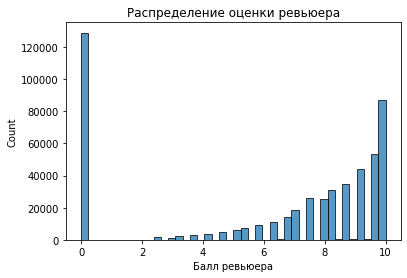

In [25]:
#Сначала посмотрим на распределение нашего целевого показателя 

fig = sns.histplot(data=hotels,x='reviewer_score')
fig.set_title('Распределение оценки ревьюера');
fig.set_xlabel('Балл ревьюера');

Как мы видим распределение ненормальное, большинство оценок около 0 или около 10.
Возможно стоит убрать часть экстримальных значений

Построим график зависимости среднего балла отеля и оценки ревьюера

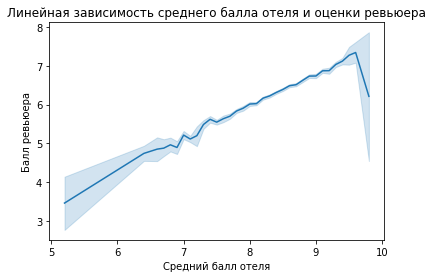

In [26]:
fig = sns.lineplot(data=hotels,x='average_score',y='reviewer_score')
fig.set_title('Линейная зависимость среднего балла отеля и оценки ревьюера');
fig.set_ylabel('Балл ревьюера');
fig.set_xlabel('Средний балл отеля');

Как мы видим - чем выше средний балл отеля тем выше ставит балл ревьюер.
Однако стоит заметить, что отели у которых средний балл близок к 10, получают оценку занчительно ниже средней.
Возможно к этим отелям слишком высокие требования от ревьюеров

Постороим столбчатую диаграмму показывающую средний поставленный бал в зависимости от страны отеля

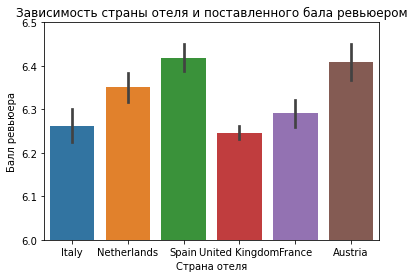

In [27]:

fig = sns.barplot(data=hotels,x='country', y='reviewer_score',estimator=np.mean)
fig.set_ylim(6,6.5)
fig.set_title('Зависимость страны отеля и поставленного бала ревьюером');
fig.set_ylabel('Балл ревьюера');
fig.set_xlabel('Страна отеля');


Наибольший средний поставленный балл у отлей из Австрии и Испании

# Отбор признаков и построение модели

Создадим копию датафрейма для экспериментов

In [28]:
hotels_copy = hotels.copy()

Проведем тесты для определения значимости влияния признаков на нашу целевую переменную.
Для непрерывных признаков применим chi2, для категориальных anova тест

In [29]:
# Непрерывные призники
num_cols = ['total_number_of_reviews',
            'total_number_of_reviews_reviewer_has_given',
           'days_since_review',
            'nights_count',
            'year'
           ]
#Категорийные признаки
cat_cols = ['average_score',
            'lat',
            'native_country',
            'review_month',
            'review_day_of_week',
            'words_negative_count_ratio',                
            'words_positive_count_ratio']

x_1 = hotels_copy.drop(['reviewer_score','part'],axis = 1)  
y_1 = hotels_copy['reviewer_score'].astype(int)


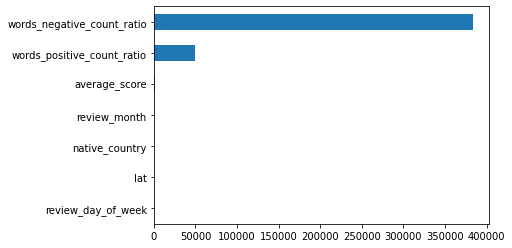

In [30]:
from sklearn.feature_selection import chi2

imp_cat = pd.Series(chi2(x_1[cat_cols], y_1)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

широта, день недели,счет  оказывают наименьшее влияние на целевой показатель.
Можно задуматься об удалении некоторых признаков

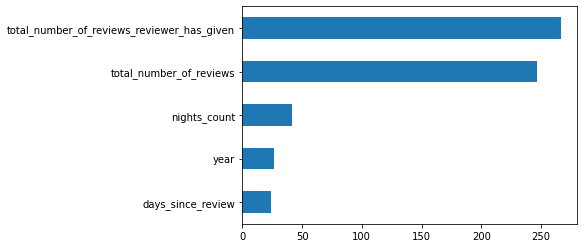

In [31]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(x_1[num_cols], y_1)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Наиболее сильное влияние на поставленный рейтинг оказывает общее количество отзывов которое оставил ревьюер

Проверим наши данные на наличие мультиколлинеарности, создадим тепловую карту, в качестве метода применим просчет коллинеарности по Спирмену.

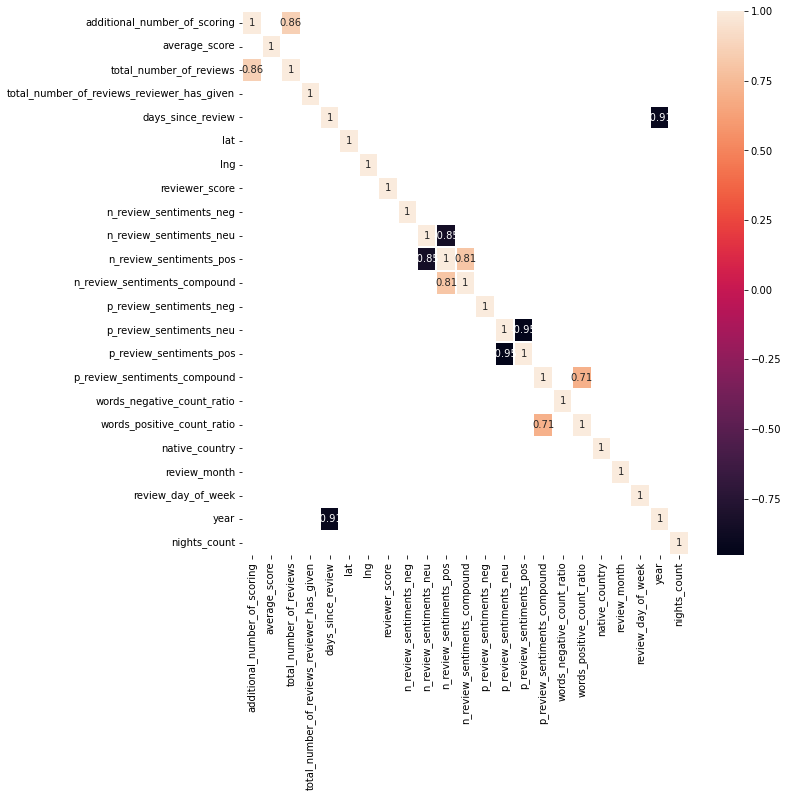

In [32]:
fig = plt.figure(figsize=(10,10))
mask1 = hotels_copy.corr('spearman') >= 0.7
mask2 = hotels_copy.corr('spearman') <= -0.7
corr_map = hotels_copy.drop('part',axis=1).corr('spearman')
sns.heatmap(corr_map[mask1|mask2],annot=True,linewidth=0.3);

In [33]:
# Удалим сильно коллерирующие признаки, а так же признаки которые наименее важны для нашей модели(
# список может поменяться в зависимости от итоговой точности)
hotels_copy.drop(
    ['city','hotel_name','lat','lng','year',
     'country','reviewer_nationality','negative_review','positive_review',
    'negative_review_sentiments','positive_review_sentiments'],axis=1,inplace=True)
    

Закодируем признаки: 
название страны
а также наши теги:
цель поездки и компания с кем ревьюер путешествует

в OnehotEncoding
    

In [34]:
hotels_copy = pd.get_dummies(hotels_copy,columns=['num_of_visitors','purpose_of_trip','review_day_of_week','review_month'])



In [35]:
# Разделим наш датасет на тренировочный и тестовый по созданному ранее признаку
train_data = hotels_copy[hotels_copy['part'] == 0].drop('part',axis=1)
test_data = hotels_copy[hotels_copy['part'] == 1].drop('part',axis=1)


In [36]:
# Создаем переменную с целевым признаком, для дальнешей загрузки в модель
y = train_data['reviewer_score']
X = train_data.drop('reviewer_score',axis=1)

In [37]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [38]:
# проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 45), (386496, 45), (386496, 44), (309196, 44), (77300, 44))

In [39]:
%%time

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1,random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min


CPU times: user 12min 21s, sys: 2.84 s, total: 12min 24s
Wall time: 3min 10s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [40]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [41]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred),4))

MAPE: 0.1225


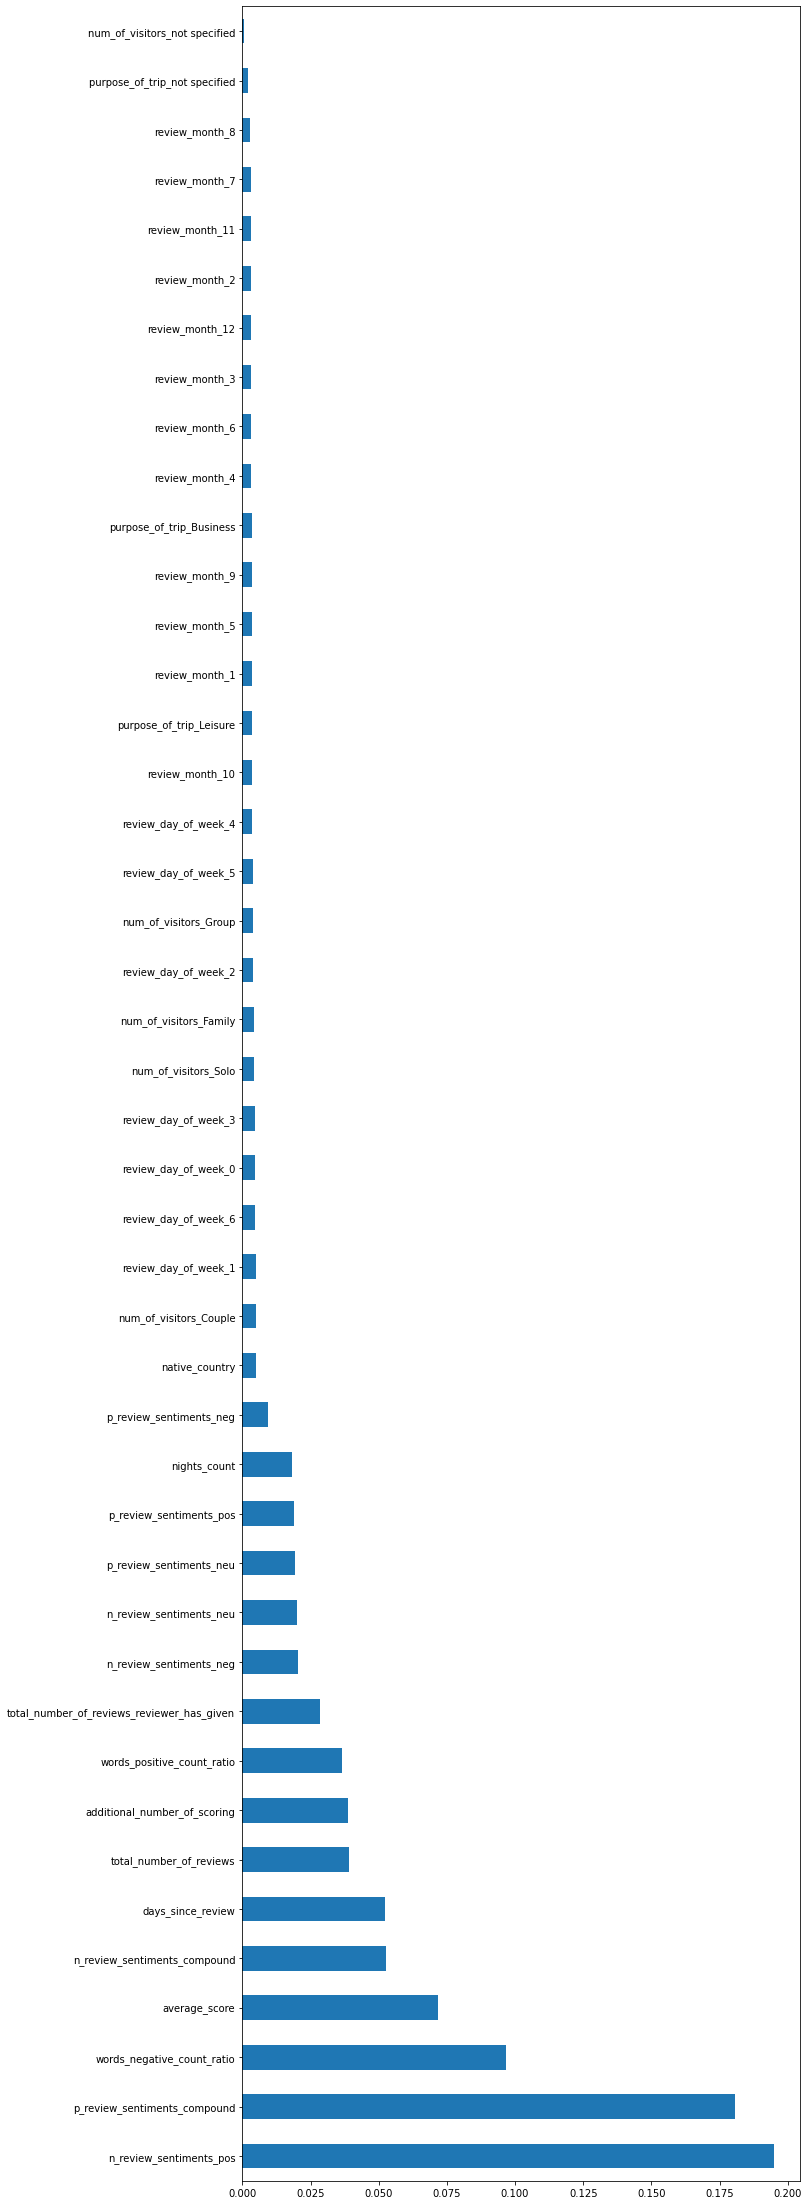

In [42]:
# Выведем показатели на которые в большей степени опиралась модель для предсказания
fig = plt.figure(figsize=(10,40))
plot = pd.Series(regr.feature_importances_,index = X.columns)
plot.nlargest(50).plot(kind='barh');

In [43]:
test_data.sample(10)

,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,...,review_month_3,review_month_4,review_month_5,review_month_6,review_month_7,review_month_8,review_month_9,review_month_10,review_month_11,review_month_12
62174,947,8.7,8177,1,474,0.0,0.211,0.789,0.000,-0.3400,...,0,1,0,0,0,0,0,0,0,0
24510,1322,8.4,6117,2,322,0.0,0.177,0.823,0.000,-0.7096,...,0,0,0,0,0,0,1,0,0,0
84140,1427,8.8,4305,1,525,0.0,0.099,0.901,0.000,-0.2960,...,0,0,0,0,0,0,0,0,0,0
91806,404,8.9,2197,1,371,0.0,0.227,0.515,0.258,0.0772,...,0,0,0,0,1,0,0,0,0,0
109626,215,7.8,1945,5,20,0.0,0.000,0.000,1.000,0.5574,...,0,0,0,0,1,0,0,0,0,0
81389,1444,7.8,5726,1,129,0.0,0.228,0.647,0.125,-0.3400,...,1,0,0,0,0,0,0,0,0,0
32176,555,8.4,4410,1,522,0.0,0.000,0.785,0.215,0.6249,...,0,0,0,0,0,0,0,0,0,0
69717,144,8.1,1363,9,557,0.0,0.000,0.000,1.000,0.5574,...,0,0,0,0,0,0,0,0,0,0
13134,541,8.0,2367,1,717,0.0,0.239,0.710,0.052,-0.7783,...,0,0,0,0,0,1,0,0,0,0
25598,563,8.3,10842,21,53,0.0,0.044,0.900,0.056,0.1531,...,0,0,0,1,0,0,0,0,0,0


In [44]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [45]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [46]:
predict_submission

array([8.573, 7.222, 8.405, ..., 8.133, 9.728, 6.984])

In [47]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.573,488440
1,7.222,274649
2,8.405,374688
3,9.770,404352
4,9.486,451596
5,8.692,302161
6,7.957,317079
7,7.901,13963
8,8.430,159785
9,7.119,195089
